In [9]:
# Required libraries

import os
from collections import Counter
import calendar

from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask.dataframe as dd

In [10]:
# Preparing the dataset for work

def preparation_dataset(file_name):

    # return data_frame
    data_frame = dd.read_csv(file_name)
    
    # remove duplicates
    data_frame = data_frame.drop_duplicates()
    
            #with duplicates as (
            #    select id, row_number() over(
            #        partition by name, height, birthdate
            #        order by id) as row_num
            #    from persona)
            #delete from persona
            #where id in (
            #    select id 
            #from duplicates
            #where row_num > 1);
    
    # remove all empty strings
    data_frame = data_frame.dropna(how='all')

            # delete from persona
            # where
            #     (name is null or name = '') and
            #     (height is null or height::text = '') and
            #     (birthdate is null or birthdate::text = '');

    # remove all cells without numbers   
    mask = ~(data_frame['Height'].astype(str).str.contains(r'\d') | data_frame['BirthDate'].str.contains(r'\d'))
    data_frame = data_frame[~mask]

            # delete from persona
            # where
            #     (height::text !~ '\d' or height is null) and
            #     (birthdate::text !~ '\d' or birthdate is null);

    # remove by time
    data_frame['BirthDate'] = dd.to_datetime(data_frame['BirthDate'], errors='coerce')
    data_frame = data_frame[~data_frame['BirthDate'].dt.hour.between(1, 3)]

            # delete from persona
            # where
            #     birthdate::time between '01:00:00' and '03:00:00';

    result = data_frame.compute()

    return result


In [15]:
# Get metrics and join

def metrics_calculation(data_frame):

    data_frame['Hour'] = pd.to_datetime(data_frame['BirthDate']).dt.hour

    grouped = data_frame.groupby('Hour')
    result = pd.DataFrame({
        'UniqueCounts': grouped['Name'].nunique(),

            # select 
            #     count(distinct(name)), 
            #     extract(hour from birthdate) as hour
            # from persona
            # group by hour
            # order by hour;

        'MeanValues': grouped['Height'].mean(),

            # select 
            #     extract(hour from birthdate) as hour,
            #     avg(height) as avg_height
            # from persona
            # group by hour
            # order by hour;

        'MedianValues': grouped['Height'].median()

            # select
            #     extract(hour from birthdate) as hour,
            #     percentile_cont(0.5) within group (order by height) as median
            # from persona
            # where height is not null
            # group by hour ;

    })
    data_frame = data_frame.join(result, on='Hour', how='left')
    return data_frame


In [12]:
# Vizualization

def get_histogram(data_frame, fig_size):
    '''
    Having a large sample and normal distribution of data, 
    I calculated a confidence interval based on the sample - 
    I used the z-distribution.
    '''
    sample = data_frame['Height']

    # calculate mean and standart deviation
    mean = np.mean(sample)
    std_dev = np.std(sample)
    n = len(sample)

    # calculate of 95% cinfidience interval
    confidience_level = 0.95
    Z = stats.norm.ppf((1 + confidience_level) / 2)

    # formula for confidience level
    margin_of_error = Z * (std_dev / np.sqrt(n))
    confidience_interval = (mean - margin_of_error, mean + margin_of_error)

    plt.figure(figsize=fig_size)
    plt.hist(sample, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(confidience_interval[0], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Lower: {confidience_interval[0]:.2f}')
    plt.axvline(confidience_interval[1], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Upper: {confidience_interval[1]:.2f}')
    plt.title('Histogram with 95% Confidence Interval')
    plt.xlabel('Salary')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def get_graph(data_frame, fig_size):
    data_frame['BirthDate'] = pd.to_datetime(data_frame['BirthDate'])
    data_frame['month'] = data_frame['BirthDate'].dt.month
    monthly_mean = data_frame.groupby('month')['Height'].mean()

    monthly_mean.index = [calendar.month_abbr[int(month)] for month in monthly_mean.index]

    plt.figure(figsize=fig_size)
    plt.plot(monthly_mean.index, monthly_mean.values)
    plt.title('Graph of the average value of the Height column')
    plt.xlabel('Month')
    plt.ylabel('Height')
    plt.grid(True)
    plt.show()

def get_heatmap(data_frame, fig_size):
    def count_char_frequencies(texts):
        freq = Counter()
        for text in texts:
            if not pd.isna(text):
                freq.update(text)
        return dict(freq)

    frequencies = count_char_frequencies(data_frame['Name'])

    frq_matrix = pd.DataFrame.from_dict(frequencies, orient='index', columns=['Frequency'])
    frq_matrix = frq_matrix.T
    frq_matrix

    plt.figure(figsize=fig_size)
    sns.heatmap(frq_matrix, annot=True, cmap='plasma', linewidths=0.5, annot_kws={'rotation': 90})
    plt.title('Heat map by symbol frequency')
    plt.xlabel('Symbols')
    plt.show()

def ploting(data_frame, fig_size):

    get_histogram(data_frame, fig_size)
    get_graph(data_frame, fig_size)
    get_heatmap(data_frame, fig_size)


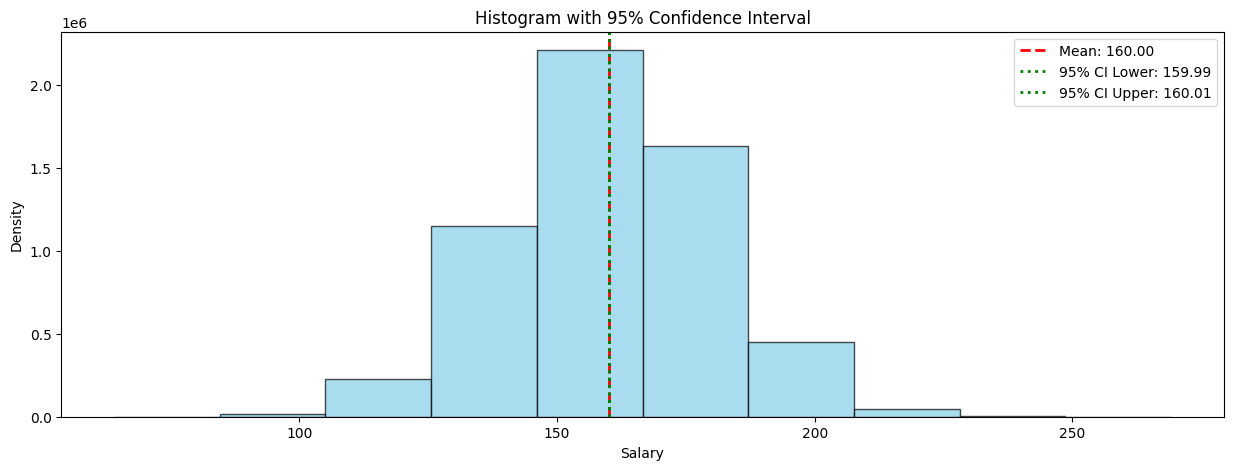

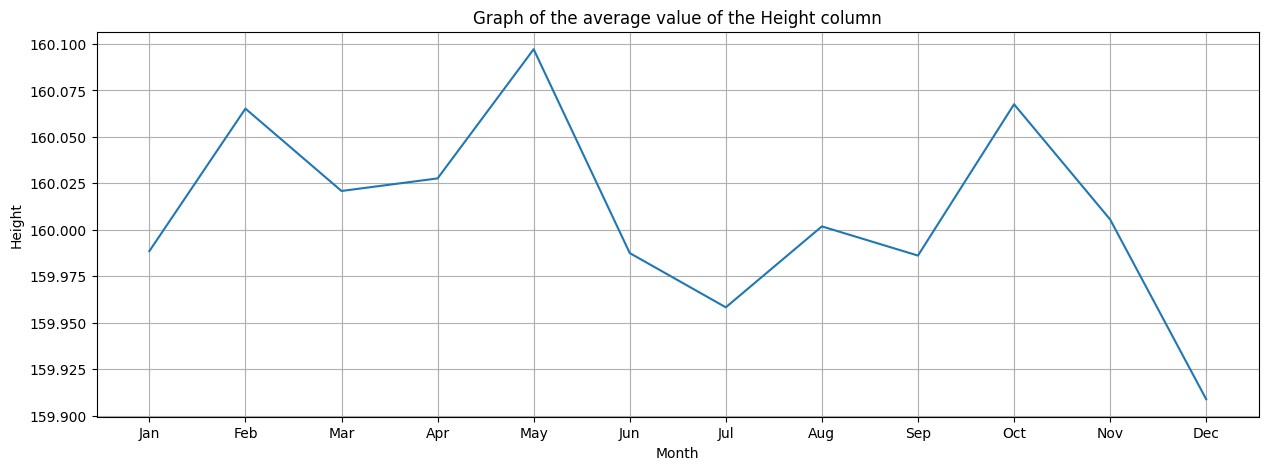

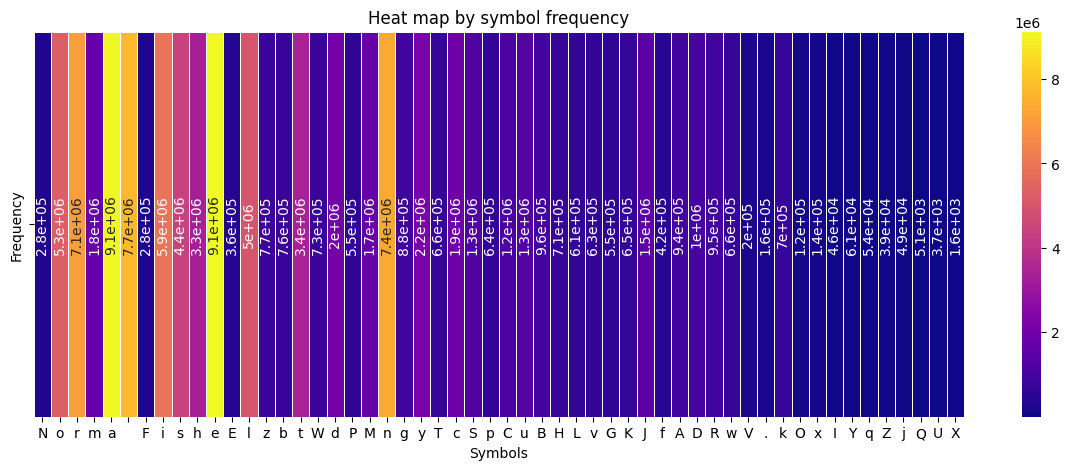

In [ ]:
# Processing

figure_size = (15, 5)
file_name = 'persona_db.csv.gz'

df = preparation_dataset(file_name)
df = metrics_calculation(df)

ploting(df, figure_size)

# best results:
# 1m 48.7

# equipment used
# Core(TM) i5-3210M 2.50GHz
# Core - 2
# Threads per core - 2
# RAM 8GB

